<h1>Aikasarjat: Ilman CO<sub>2</sub>-pitoisuuksia kuukausittain</h1>

In [1]:
#Tuon ohjelmakirjastot
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Tiedoston avaaminen
df = pd.read_excel('http://taanila.fi/CO2.xlsx')

#Aikaleimat indeksiin
df.index = pd.to_datetime(df['Kuukausi'], format="%Y-%m")

#Pudotetaan tarpeettomaksi käynyt sarake pois
df = df.drop('Kuukausi', axis=1)

df

,CO2
Kuukausi,
1999-12-01,368.04
2000-01-01,369.25
2000-02-01,369.50
2000-03-01,370.56
2000-04-01,371.82
...,...
2019-04-01,413.32
2019-05-01,414.66
2019-06-01,413.92


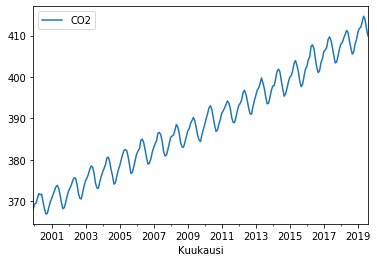

In [3]:
#Aikasarja viivakuviona
df.plot()
#Selkeä trendi ja kausittaista vaihtelua, joten mallintamiseen käytetään Holt-Winterin menetelmää

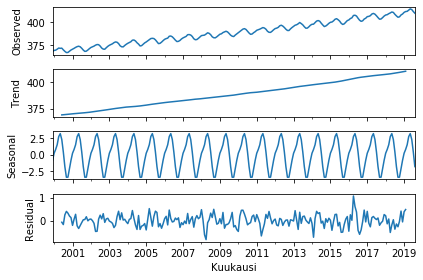

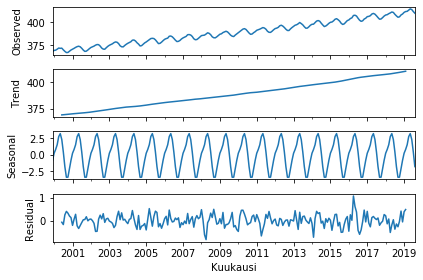

In [4]:
#Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
#Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
#Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu

from statsmodels.tsa.api import seasonal_decompose

seasonal_decompose(df['CO2']).plot()

In [5]:
#Mallin sovitus
from statsmodels.tsa.api import ExponentialSmoothing

#Trendi ja kausivaihtelu huomioidaan
#Kausivaihtelu huomoidaan tulomallina (mul)
malli = ExponentialSmoothing(df['CO2'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 12).fit()

C:\Users\Henri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [6]:
#malli-olion avulla saadaan mallin mukaan simuloidut ennusteet (fittedvalues)
df['Ennuste'] = malli.fittedvalues
df

,CO2,Ennuste
Kuukausi,,
1999-12-01,368.04,367.951487
2000-01-01,369.25,369.187432
2000-02-01,369.50,369.920996
2000-03-01,370.56,370.547237
2000-04-01,371.82,371.897175
...,...,...
2019-04-01,413.32,413.698799
2019-05-01,414.66,414.148818
2019-06-01,413.92,413.706182


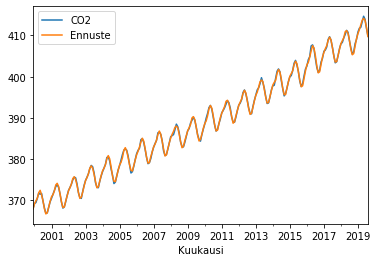

In [7]:
#Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kuvioon
df.plot()

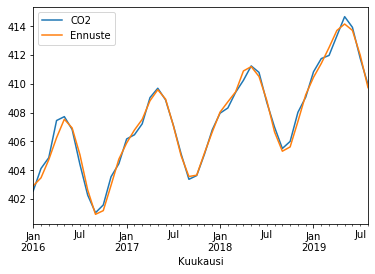

In [8]:
df['2016-01-01':].plot()

In [9]:
#Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,CO2,Ennuste,Ennustevirhe
Kuukausi,,,
1999-12-01,368.04,367.951487,0.088513
2000-01-01,369.25,369.187432,0.062568
2000-02-01,369.50,369.920996,-0.420996
2000-03-01,370.56,370.547237,0.012763
2000-04-01,371.82,371.897175,-0.077175
...,...,...,...
2019-04-01,413.32,413.698799,-0.378799
2019-05-01,414.66,414.148818,0.511182
2019-06-01,413.92,413.706182,0.213818


In [10]:
#Mallin hyvyys
from sklearn.metrics import mean_squared_error, mean_absolute_error

#ennustevirheiden neliöiden keskiarvo (MSE = mean squared error)
print('mean squared error', mean_squared_error(df['CO2'], df['Ennuste']))
#ennustevirheiden itseisarvojen keskiarvo (MAD = mean absolute deviation)
print('mean absolute error', mean_absolute_error(df['CO2'], df['Ennuste']))

mean squared error 0.09484177013802904
mean absolute error 0.24003791267144983


Text(0, 0.5, 'Ennustevirhe')

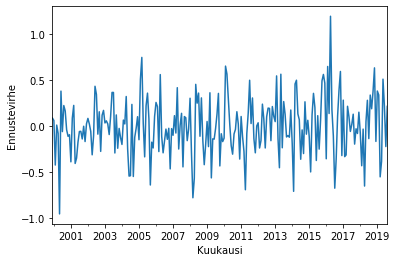

In [11]:
#Ennustevirheet aikasarjana
#On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut CO2')

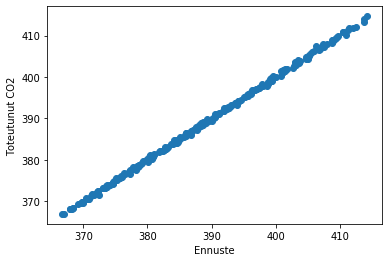

In [12]:
#Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
#vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['CO2'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut CO2')

In [13]:
#Ennusteiden laskeminen seuraavalle viidelle vuodelle
periods = 12*5 #ennustettavien ajankohtien lukumäärä
index = pd.date_range('2019-09-01', #ensimmäisen ennusteen aikaleima
                      periods = periods,
                      freq = 'MS') #ennustettavien ajankohtien frekvenssi, month start frequency (MS)
ennusteet = malli.forecast(periods)

#Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, columns = ['Ennuste'])
df_ennuste

,Ennuste
2019-09-01,408.324331
2019-10-01,408.521749
2019-11-01,410.094212
2019-12-01,411.611169
2020-01-01,412.918927
2020-02-01,413.680182
2020-03-01,414.611154
2020-04-01,416.092058
2020-05-01,416.747704
2020-06-01,416.026495


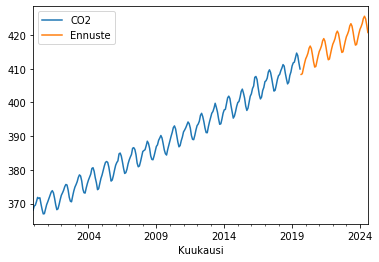

In [14]:
#Viivakuvio havainnoista
df['CO2'].plot(legend=True)

#Ennusteet kuvioon
df_ennuste['Ennuste'].plot(legend=True)

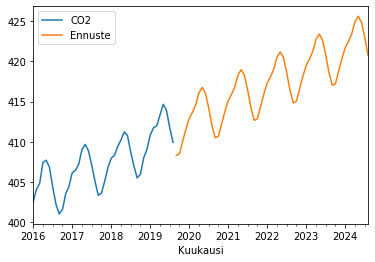

In [15]:
df['CO2']['2016-01-01':].plot(legend=True)
df_ennuste['Ennuste'].plot(legend=True)

In [16]:
#Ennusteet alkuperäisen aikasarjan perään
df = pd.concat([df, df_ennuste])
df

C:\Users\Henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,CO2,Ennuste,Ennustevirhe
1999-12-01,368.04,367.951487,0.088513
2000-01-01,369.25,369.187432,0.062568
2000-02-01,369.50,369.920996,-0.420996
2000-03-01,370.56,370.547237,0.012763
2000-04-01,371.82,371.897175,-0.077175
...,...,...,...
2024-04-01,NaN,424.931370,NaN
2024-05-01,NaN,425.597028,NaN
2024-06-01,NaN,424.856599,NaN
2024-07-01,NaN,422.972538,NaN


In [17]:
#Mallin statistiikkaa
malli.params

{'smoothing_level': 0.5350763699976933,
 'smoothing_slope': 1.3320968144320087e-14,
 'smoothing_seasonal': 0.0,
 'damping_slope': nan,
 'initial_level': 387.4064118281093,
 'initial_slope': 0.19223663806213875,
 'initial_seasons': array([0.94931055, 0.95190464, 0.95323712, 0.95495933, 0.95794609,
        0.9590311 , 0.95694811, 0.9522921 , 0.94692708, 0.94298427,
        0.94302153, 0.94623147]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}